In [1]:
"""
    Returns a cleaned X and y dataset to be used for classification.
"""
import os
import cv2
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import misc
from matplotlib.image import imread
import matplotlib.pyplot as plt
import keras

import joblib
from sklearn.model_selection import train_test_split, cross_validate

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


from random import randint
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import optimizers



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Uncomment the following to check whether you have access to a GPU in Google Colab
# See further instructione below.
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') 

[]

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from packaging import version
import sklearn
import tensorflow as tf
tensorflow_version = tf.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2 or later (e.g. 2.4)".format(tensorflow_version))
elif version.parse(tensorflow_version) < version.parse("2.4.0"):
    print("Tensorflow version is <2.4. This will likely work but we recommend updating to 2.4".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


In [5]:
PATH=r"C:\Users\Jeroen Gijsbers\OneDrive - TU Eindhoven\Uni\Master\Jaar 1\Kwartiel 3\2AMV10 - Visual Analytics\Project\2AMV10-group-16"
PATH_m = r"/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16"
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
IMAGE_CHANNEL = 3
stop_training = False

Helper functions

In [6]:
def process_img(sample):
  try:
    # print(sample.shape)
    sample = np.array(sample)
    sample = sample / 255.
    sample = cv2.resize(sample, (IMG_SIZE, IMG_SIZE))
    return sample.reshape(IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)
  except ValueError or AttributeError:
    print(sample, "returned an error")


def read_data():
    """
        Reads the images and returns them as arrays X and y

        returns: X      array containing np-array-representation of images
                 y      array containing corresponding labels
    """
    #print(os.curdir)
    #os.chdir('../data/trainingData/TrainingImages')
    X = []
    y = []
    labels = []
    sys.path.insert(0, PATH_m)

    path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data/trainingData/TrainingImages"
    i = 0
    limit = 100000
    for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
        print(label)
        labels.append(label)
        for image in [name for name in os.listdir(f"{path}/{label}")]:
            if image.endswith('.db'):
              pass
            else:
              # print(f"{path}/{label}/{image}")
              X.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
              # print(label)
              y.append(label)
              i+= 1
            if i == limit:
                break
        if i == limit:
            break
    return np.array(X), y, labels#.reshape(50, 256*256), y, labels


# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def show_images(grayscale=False, display_test=False):
        """
            Shows 10 random images from the dataset
        """
        def plot_images(X, y, grayscale=False, display_test=False):
            fig, axes = plt.subplots(1, len(X), figsize=(15,30))
            for n in range(len(X)):
                if grayscale:
                    axes[n].imshow(X[n], cmap='gray')
                else:
                    axes[n].imshow(X[n])
                # print(f"1: {y[n]}")
                # print(f"2: {np.argmax(y[n])} ")
                # print(f"3: {self.labels[:5]}")
                # print(f"4: {self.labels[np.argmin(y[n])]}")
                axes[n].set_xlabel(y[n])
                axes[n].set_xticks(()), axes[n].set_yticks(())
            plt.show()

        images = [randint(0,len(X_train)-1) for i in range(5)]
        # print(images)
        X_random = [X_train[i] for i in images]
        y_random = [y_train[i] for i in images]
        plot_images(X_random, y_random)

        if display_test:
            images = [randint(0,len(X_test)-1) for i in range(5)]
            X_random = [X_test[i] for i in images]
            y_random = [y_test[i] for i in images]
            plot_images(X_random, y_random)


In [7]:
X, y, labels = read_data()

legoBracelet
metalKey
paperPlate
spiderRing
vancouverCards
voiceRecorder
silverStraw
redBow
turtle
pumpkinNotes
rainbowPens
trophy
stickerBox
rubiksCube
noisemaker
partyFavor
miniCards
pinkEraser
yellowBag
redWhistle
plaidPencil
yellowBalloon
redDart
sign
pinkCandle
birdCall
blueSunglasses
brownDie
cactusPaper
canadaPencil
carabiner
cloudSign
cowbell
cupcakePaper
eyeball
foamDart
gClamp
giftBag
glassBead
gyroscope
hairClip
hairRoller
lavenderDie


In [8]:
X.shape

(516, 160, 160, 3)

In [9]:
len(np.unique(y))

43

In [10]:
len(labels)

43

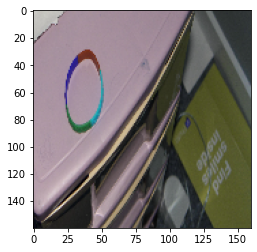

In [11]:
plt.imshow(X[1])

In [12]:
labels

['legoBracelet',
 'metalKey',
 'paperPlate',
 'spiderRing',
 'vancouverCards',
 'voiceRecorder',
 'silverStraw',
 'redBow',
 'turtle',
 'pumpkinNotes',
 'rainbowPens',
 'trophy',
 'stickerBox',
 'rubiksCube',
 'noisemaker',
 'partyFavor',
 'miniCards',
 'pinkEraser',
 'yellowBag',
 'redWhistle',
 'plaidPencil',
 'yellowBalloon',
 'redDart',
 'sign',
 'pinkCandle',
 'birdCall',
 'blueSunglasses',
 'brownDie',
 'cactusPaper',
 'canadaPencil',
 'carabiner',
 'cloudSign',
 'cowbell',
 'cupcakePaper',
 'eyeball',
 'foamDart',
 'gClamp',
 'giftBag',
 'glassBead',
 'gyroscope',
 'hairClip',
 'hairRoller',
 'lavenderDie']

In [13]:
# Don't change the name of these variables


from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

X_train = np.repeat(X_train, 10, axis=0)
y_train = np.repeat(y_train, 10, axis=0)
print(X_train.shape, y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)



(4120, 160, 160, 3) (4120,)


In [14]:
labels = pd.unique(y_train)

In [15]:
# labels = pd.unique(y_train)
# len(labels)

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le.fit(y_val)
y_val = le.transform(y_val)

le.fit(y_test)
y_test = le.transform(y_test)





In [17]:
y_val

array([24, 33, 22, 18, 37, 39, 42, 16, 32, 24, 36,  4, 41, 35, 38, 12,  8,
        2, 20, 21, 36, 16,  7, 42, 41, 38, 24, 42,  8, 29, 24, 12, 22, 21,
        5, 13, 22,  2, 15, 19, 39, 42, 23, 33, 36, 26, 10,  1,  4, 28,  1,
       19, 27, 13, 30,  2, 23, 33,  9, 13, 21, 26, 42, 27, 33,  5, 11,  6,
       14, 11, 13, 34,  0, 42, 19, 34,  3, 42, 12,  2,  4, 16,  6, 12, 10,
       16, 13, 42, 40, 31, 25, 13, 42, 31, 14, 11,  9, 19,  9, 30, 36,  1,
       29, 17,  7, 23, 26,  9, 24, 10, 35, 15, 22, 30,  4, 27, 35, 35, 36,
       20, 30,  9,  7, 38,  0,  2, 35, 39, 16, 42, 33,  3, 20, 28,  3,  4,
       25, 22, 19, 17,  8, 22, 23,  1, 20, 21, 39,  6, 42, 19, 29, 11, 41,
       18,  1, 25, 40, 36, 34, 38,  4, 37,  2,  0, 29, 26, 28, 38, 22,  6,
       21,  5, 14, 42, 10,  0,  6, 16, 35, 31, 36, 31, 25, 40, 23, 12, 33,
       17, 23, 23,  3, 16, 30, 42, 30, 12, 36,  8, 31, 22,  5,  3, 10,  9,
        1, 36, 27, 10, 13, 40,  1, 28, 10, 31, 37,  3, 10,  2, 18, 26, 19,
        7, 41, 22, 32, 33

In [18]:
le.fit(y)
y = le.transform(y)


In [19]:
pd.unique(y_train)

array([39, 30, 25,  4, 35,  0, 15, 13, 28, 20, 40, 12, 19, 21, 29,  8, 32,
       14,  9, 26, 11,  1, 17, 22,  6, 16, 34,  3,  2, 27, 24, 36, 23, 37,
       33,  7,  5, 42, 41, 31, 38, 18, 10])

In [20]:
classes = dict(zip(pd.unique(y_train), labels))
classes

{0: 'birdCall',
 1: 'blueSunglasses',
 2: 'brownDie',
 3: 'cactusPaper',
 4: 'canadaPencil',
 5: 'carabiner',
 6: 'cloudSign',
 7: 'cowbell',
 8: 'cupcakePaper',
 9: 'eyeball',
 10: 'foamDart',
 11: 'gClamp',
 12: 'giftBag',
 13: 'glassBead',
 14: 'gyroscope',
 15: 'hairClip',
 16: 'hairRoller',
 17: 'lavenderDie',
 18: 'legoBracelet',
 19: 'metalKey',
 20: 'miniCards',
 21: 'noisemaker',
 22: 'paperPlate',
 23: 'partyFavor',
 24: 'pinkCandle',
 25: 'pinkEraser',
 26: 'plaidPencil',
 27: 'pumpkinNotes',
 28: 'rainbowPens',
 29: 'redBow',
 30: 'redDart',
 31: 'redWhistle',
 32: 'rubiksCube',
 33: 'sign',
 34: 'silverStraw',
 35: 'spiderRing',
 36: 'stickerBox',
 37: 'trophy',
 38: 'turtle',
 39: 'vancouverCards',
 40: 'voiceRecorder',
 41: 'yellowBag',
 42: 'yellowBalloon'}

In [21]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
y_train.shape

(3296, 43)

In [23]:
y_val.shape

(824, 43)

In [24]:
y_test.shape


(104, 43)

birdCall


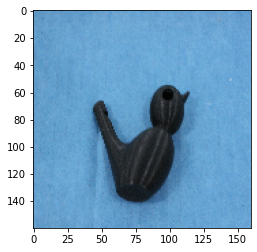

In [25]:
plt.imshow(X_train[5])
print(classes[np.argmax(y_train[5])])

noisemaker


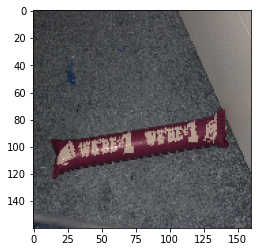

In [26]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [27]:
evaluation_split = np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

In [28]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Helper function to format answers
def print_answer(ans):
    output = ""
    for line in ans.splitlines()[0:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
    

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Evaluation harness
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}

    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val), callbacks=[callback])
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

In [29]:
print(y_train.shape[1])
print(X_train.shape, y_train.shape)

43
(3296, 160, 160, 3) (3296, 43)


In [30]:
print(y_val.shape[1])
print(X_val.shape, y_val.shape)

43
(824, 160, 160, 3) (824, 43)


In [31]:
print(y_test.shape[1])
print(X_test.shape, y_test.shape)

43
(104, 160, 160, 3) (104, 43)


In [32]:
y = to_categorical(y)

In [33]:
y_val[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

noisemaker


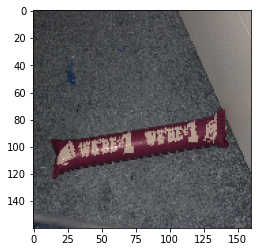

In [34]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [35]:
def augment_data():
    """ Augments the data and returns a generator and the validation data and labels
    """
    # Boilerplate code. You can change this however you like.
    generator = ImageDataGenerator(
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rotation_range=360
                                   ).flow(X_train, y_train)
    return generator, X_test, y_test

In [36]:
# Toy usage example
from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_toy_model():
    model = models.Sequential()
    model.add(MobileNetV2(input_shape=(160,160,3),
                        alpha=1.0,
                        include_top=False,
                        weights="imagenet",
                        input_tensor=None,
                        pooling=None
                       ))
    # I tried unfreezing in the function below but it didnt work well
    for layer in model.layers[:1]:
      layer.trainable = False

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(y_val.shape[1], activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model


# First build and store


In [37]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

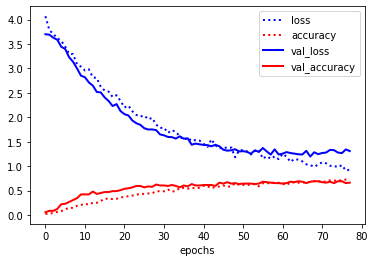

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [38]:
run_evaluation("toy_example", build_toy_model, augment_data(), 
               PATH_m, generator=True, epochs=100, steps_per_epoch=20)

In [39]:
from sklearn.metrics import accuracy_score

def evaluate_model(name):
    model = load_model_from_file(PATH_m, name, ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)
    print(f"The accuracy is: {accuracy_score(preds, y_test_c)}")
    return accuracy_score(preds, y_test_c)
test_accuracy_2_1 = evaluate_model("toy_example")


The accuracy is: 0.6634615384615384


In [40]:
model = load_model_from_file(PATH_m, 'toy_example', '.h5')

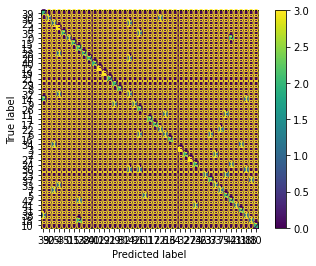

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)

    cm = ConfusionMatrixDisplay(confusion_matrix(y_test_c, preds), display_labels=classes)
    cm.plot()
    plt.show()
plot_confusion_matrix()

noisemaker


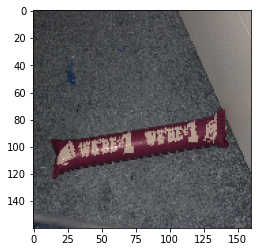

In [42]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

[ 2  8 12 13 14]
34 28
19 31
0 40
39 26
30 38


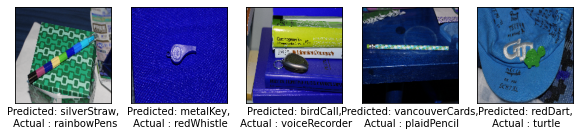

In [43]:
def plot_misclassifications():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    y_pred = model.predict(X_test)
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

    fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    print(misclassified_samples[:5])
    for nr, i in enumerate(misclassified_samples[:5]):
        axes[nr].imshow(X_test[i])
        print(np.argmax(y_pred[i]), np.argmax(y_test[i]))
        axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (classes[np.argmax(y_pred[i])],classes[np.argmax(y_test[i])]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())

    plt.show()


plot_misclassifications()

stickerBox


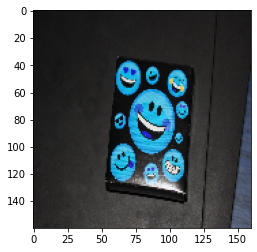

In [44]:
plt.imshow(X_test[0]);
print(classes[np.argmax(y_test[0])])


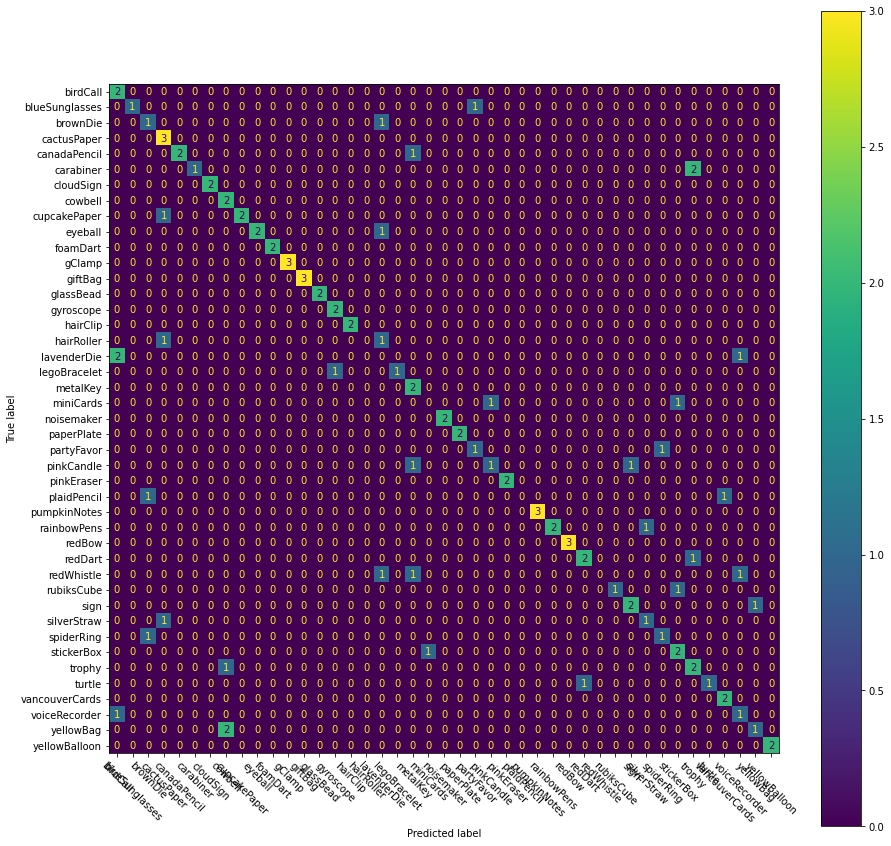

In [72]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def preds_to_json(test_set=X_test, plot=True):
  """
  Function does not return anything but makes a new file, plots if you want it to
  """
  
  X_test = test_set
  model = load_model_from_file(PATH_m, "toy_example", ".h5")
  preds = model.predict(X_test)

  a2 = np.argmax(preds, axis=1)
  a1 = np.argmax(y_test, axis=1)
  
  a_names = np.vectorize(classes.get)(a1)
  b_names = np.vectorize(classes.get)(a2)

  data = confusion_matrix(a_names, b_names)

  manual_dict = {}
  i = 0
  for col in data:
    colname = np.unique(a_names)[i]
    # print(colname)

    temp_dict = {str(colname) : data[i].tolist()}
    # print(temp_dict)
    manual_dict.update(temp_dict)
    i+=1

  with open('cm.json', 'w') as file:
      json.dump(manual_dict, file)

  if plot:
    cm = ConfusionMatrixDisplay(confusion_matrix(a_names, b_names), display_labels=np.unique(a_names))
    fig, ax = plt.subplots(figsize=(15,15))
    cm.plot(ax=ax)
    plt.xticks(rotation = -45)
    plt.show()

preds_to_json()

In [46]:
print(PATH_m)

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16


In [47]:
import time 
def read_test():

  """
        Reads the images and returns them as arrays X and y

        returns: X_t      array containing np-array-representation of images
                 y      array containing corresponding labels
  """

  #print(os.curdir)
  #os.chdir('../data/trainingData/TrainingImages')
  X_t = []
  captions = []
  person_order = []
  person_n = []
  sys.path.insert(0, PATH_m)
  t_0 = time.perf_counter()
  path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data"
  i = 0
  limit = 100000
  for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
      print(label)
      if not 'Person' in label:
        break
      person_order.append(label)
      t_1 = time.perf_counter()
      for image in [name for name in os.listdir(f"{path}/{label}")]:
          if image.endswith('.db'):
            break
          if image.endswith('.txt'):
            break # skip captions for now
            # TODO get text out of file instead of filename
            # with open(f"{path}/{label}/{image}", "r") as f:
            #   print(image)
            #   print(f.readlines())
            #   captions.append(f.readlines())
          #X.append(cv2.imread(f"{path}/{label}/{image}"))
          else:
            person_n.append(label)
            X_t.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
            t_2 = time.perf_counter()
            print(f"Doing image {image} took {t_2-t_1}")
            # print(label)
            i+= 1
          if i == limit:
              break
      if i == limit:
          break
      t_4 = time.perf_counter()
      print(f"Doing person : {label} took {t_4 - t_1}")
  t_3 = time.perf_counter()
  print(f"Done in {t_3-t_0}")  
  return np.array(X_t), captions, person_n#.reshape(50, 256*256), y, labels


X_t, captions, person_n = read_test()

Person40
Doing image Person40_1.jpg took 0.012614811999810627
Doing image Person40_10.jpg took 0.827922086999024
Doing person : Person40 took 0.8286570500004018
Person38
Doing image Person38_1.jpg took 0.057676538001032895
Doing image Person38_10.jpg took 0.10758973799966043
Doing image Person38_11.jpg took 0.1579798849998042
Doing image Person38_12.jpg took 0.21295424600066326
Doing image Person38_13.jpg took 0.268082864000462
Doing image Person38_14.jpg took 0.3200192730000708
Doing image Person38_15.jpg took 0.36909171899969806
Doing image Person38_16.jpg took 0.4231115700004011
Doing image Person38_2.jpg took 0.48671988299975055
Doing image Person38_3.jpg took 0.5365895689992612
Doing image Person38_4.jpg took 0.588653589000387
Doing image Person38_5.jpg took 0.6407236480008578
Doing image Person38_6.jpg took 0.6942205840005045
Doing image Person38_7.jpg took 0.7445452600004501
Doing image Person38_8.jpg took 0.7970026769999095
Doing image Person38_9.jpg took 0.8488198180002655
Doi

In [48]:
X_t[0]

array([[[0.07058824, 0.05490196, 0.07768076],
        [0.07058824, 0.05490196, 0.0745098 ],
        [0.06666667, 0.05098039, 0.07058824],
        ...,
        [0.06813725, 0.06813725, 0.06813725],
        [0.06813725, 0.06813725, 0.06813725],
        [0.08114277, 0.08114277, 0.08114277]],

       [[0.07005208, 0.05730699, 0.06862745],
        [0.06852022, 0.05675551, 0.06459865],
        [0.06567096, 0.05390625, 0.06174939],
        ...,
        [0.06101409, 0.06101409, 0.06101409],
        [0.05735294, 0.05735294, 0.05735294],
        [0.06004902, 0.06004902, 0.06004902]],

       [[0.06887255, 0.06102941, 0.05890012],
        [0.06251532, 0.05467218, 0.05393689],
        [0.05503983, 0.05503983, 0.05503983],
        ...,
        [0.05637255, 0.05637255, 0.05637255],
        [0.06127451, 0.06127451, 0.06127451],
        [0.06813725, 0.06813725, 0.06813725]],

       ...,

       [[0.42617953, 0.4810815 , 0.55166973],
        [0.42915135, 0.48405331, 0.55464154],
        [0.39805453, 0

In [49]:
X_train[0]

array([[[0.04670588, 0.05847059, 0.07807843],
        [0.04431373, 0.05607843, 0.07568628],
        [0.04313725, 0.05490196, 0.0745098 ],
        ...,
        [0.29411765, 0.33333333, 0.40392157],
        [0.22353056, 0.27372587, 0.36000038],
        [0.23686504, 0.30745328, 0.39764936]],

       [[0.04113725, 0.05070589, 0.07772549],
        [0.04705882, 0.05529411, 0.09290196],
        [0.04490196, 0.05627451, 0.07705883],
        ...,
        [0.27333333, 0.30215686, 0.37529411],
        [0.18701918, 0.24192114, 0.31760742],
        [0.23517425, 0.27372396, 0.3447415 ]],

       [[0.04313725, 0.05764706, 0.0772549 ],
        [0.03921569, 0.04705882, 0.08627451],
        [0.04509804, 0.05686275, 0.07647059],
        ...,
        [0.32745098, 0.35490196, 0.41372549],
        [0.24039139, 0.27176394, 0.36196002],
        [0.28372587, 0.3201957 , 0.39568781]],

       ...,

       [[0.04705882, 0.05882353, 0.0745098 ],
        [0.05098039, 0.0627451 , 0.08235294],
        [0.05882353, 0

In [50]:
X_t[1] = tf.reshape(X_t[1], (160, 160, 3))

In [51]:
yt_pred = model.predict(X_t)

In [52]:
np.argmax(yt_pred[0])

1

In [53]:
person_n[0]

'Person40'

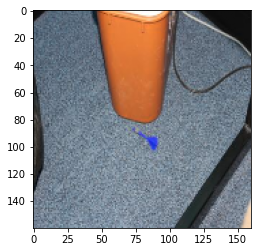

In [54]:
plt.imshow(X_t[0])

In [55]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def test_to_json(test_set=X_t, plot=True):
  """
  Function does not return anything but makes a new file, plots if you want it to
  """
  
  X_test = test_set
  model = load_model_from_file(PATH_m, "toy_example", ".h5")
  preds = model.predict(X_test)

  
  a_names = np.vectorize(classes.get)(np.argmax(preds, axis=1))


  manual_dict = {}
  i = 0
  for col in data:
    colname = np.unique(a_names)[i]
    # print(colname)

    temp_dict = {str(colname) : data[i].tolist()}
    # print(temp_dict)
    manual_dict.update(temp_dict)
    i+=1

  with open('predsxt.json', 'w') as file:
      json.dump(manual_dict, file)


preds_to_json(plot=False)

In [56]:
model = load_model_from_file(PATH_m, "toy_example", ".h5")
preds = model.predict(X_t)


a_names = np.vectorize(classes.get)(np.argmax(preds, axis=1))
a_names.shape

a_numbers = np.argmax(preds, axis=1)
print(a_numbers)


[ 1 29 35 23 19  3  0 30 29  1  9 23 29  1 23 23  7  7 39 39 20 39 40  4
 19 14 14 18 14 10  8 19 27  7 40 23  8  8  1  8  6  8  7 29 23 38 35 23
 30 14 23 23 29 29 32  6 19 39 19 24 35 13 39 23  3 23 15 13  6  9 19  9
 35 35 35 19 28 31 23 23  7 23 19  8  9  1  8 13  3 35 23 11 35 19 14 35
  0  8  1 20 11 11 11 11 17 31  6  2 23 33 37 20 23 35 27 20 39 38 28 19
 27  6 23  1 15 19 17 27 17 35 38  8 23  2  1 23  8  7  4  8 19 24  5 30
 24 19 19  0 41  1 27 33 23 13 39 26 30  8 35 13 19 24  1 13 30 35  9 30
 13  8 35  2 15  0 15 23 34 23 19 26 24 30 30 29 29 23 23 23  3 23 23 24
 19 19 34 34  8 26 19  7 23  3 19 29 38  1 23 19 13  1 29  0 13 19  3 31
 29 31 15  9  9 23 29 15 21 32 23  3 19 35 29 29 35 23 19 19 23 23 29 10
 31 23 23 19 35 10 25  7 17 19  3  9 35 35 29 23 37 35 37 17 29  8  1  2
  1  1 24 19 23 22 31  4 20 20 33 20 22 37  8 37 22 30 37 22 23 17  2 41
 31 33  0 35 33  8 26  3 38 35 35 32  2 35 16 11 25 15 35 19 32 40 35 29
 19 35 23  6 37 15 24 37 28 29 30 30 26 26 29 28  5

In [57]:
classes

{0: 'birdCall',
 1: 'blueSunglasses',
 2: 'brownDie',
 3: 'cactusPaper',
 4: 'canadaPencil',
 5: 'carabiner',
 6: 'cloudSign',
 7: 'cowbell',
 8: 'cupcakePaper',
 9: 'eyeball',
 10: 'foamDart',
 11: 'gClamp',
 12: 'giftBag',
 13: 'glassBead',
 14: 'gyroscope',
 15: 'hairClip',
 16: 'hairRoller',
 17: 'lavenderDie',
 18: 'legoBracelet',
 19: 'metalKey',
 20: 'miniCards',
 21: 'noisemaker',
 22: 'paperPlate',
 23: 'partyFavor',
 24: 'pinkCandle',
 25: 'pinkEraser',
 26: 'plaidPencil',
 27: 'pumpkinNotes',
 28: 'rainbowPens',
 29: 'redBow',
 30: 'redDart',
 31: 'redWhistle',
 32: 'rubiksCube',
 33: 'sign',
 34: 'silverStraw',
 35: 'spiderRing',
 36: 'stickerBox',
 37: 'trophy',
 38: 'turtle',
 39: 'vancouverCards',
 40: 'voiceRecorder',
 41: 'yellowBag',
 42: 'yellowBalloon'}

In [58]:
len(person_n)

676

In [59]:
from itertools import groupby

alist = [i for i, j in groupby(person_n)]

blist = a_names

listofpreds = list(zip(person_n, a_numbers))

In [60]:
results = {}                              # use a normal dictionary for our output
for k, v in listofpreds:                    # the keys may be duplicates
    results.setdefault(k[6:], []).append(int(v))
results

{'1': [39, 30, 23, 9, 23, 19, 1, 3, 42, 8, 40],
 '10': [19,
  17,
  17,
  3,
  3,
  4,
  34,
  34,
  13,
  7,
  37,
  3,
  37,
  24,
  5,
  19,
  13,
  24,
  5,
  38,
  40,
  23,
  13,
  13,
  17],
 '11': [0,
  15,
  6,
  35,
  3,
  15,
  15,
  15,
  33,
  34,
  19,
  15,
  23,
  0,
  19,
  35,
  1,
  26,
  35,
  34,
  23,
  23,
  8,
  23,
  2,
  15,
  15,
  30,
  15,
  3],
 '12': [17, 21],
 '13': [22, 1],
 '14': [8, 19, 27, 7, 40],
 '15': [21, 23, 23],
 '16': [30, 23, 19, 17, 41, 23, 7, 26, 7, 0],
 '17': [23,
  8,
  8,
  1,
  8,
  6,
  8,
  7,
  29,
  23,
  38,
  35,
  23,
  30,
  14,
  23,
  23,
  29,
  29,
  32,
  6,
  19,
  39,
  19,
  24,
  35,
  13,
  39,
  23,
  3,
  23,
  15,
  13,
  6,
  9,
  19,
  9,
  35,
  35,
  35,
  19,
  28,
  31,
  23,
  23,
  7,
  23,
  19,
  8,
  9,
  1,
  8,
  13,
  3,
  35,
  23,
  11,
  35,
  19,
  14,
  35,
  0,
  8,
  1],
 '18': [38, 7, 2, 40, 41, 19, 12, 19, 14],
 '19': [2, 9, 11, 11, 11, 29, 22, 22],
 '2': [42, 19, 1, 21, 19, 1, 1, 23, 15, 23, 

In [61]:
with open('predsxtnumerical.json', 'w') as file:
      json.dump(results, file)
      
      

In [62]:
a_numbers = [int(x) for x in a_numbers]
a_numbers

[1,
 29,
 35,
 23,
 19,
 3,
 0,
 30,
 29,
 1,
 9,
 23,
 29,
 1,
 23,
 23,
 7,
 7,
 39,
 39,
 20,
 39,
 40,
 4,
 19,
 14,
 14,
 18,
 14,
 10,
 8,
 19,
 27,
 7,
 40,
 23,
 8,
 8,
 1,
 8,
 6,
 8,
 7,
 29,
 23,
 38,
 35,
 23,
 30,
 14,
 23,
 23,
 29,
 29,
 32,
 6,
 19,
 39,
 19,
 24,
 35,
 13,
 39,
 23,
 3,
 23,
 15,
 13,
 6,
 9,
 19,
 9,
 35,
 35,
 35,
 19,
 28,
 31,
 23,
 23,
 7,
 23,
 19,
 8,
 9,
 1,
 8,
 13,
 3,
 35,
 23,
 11,
 35,
 19,
 14,
 35,
 0,
 8,
 1,
 20,
 11,
 11,
 11,
 11,
 17,
 31,
 6,
 2,
 23,
 33,
 37,
 20,
 23,
 35,
 27,
 20,
 39,
 38,
 28,
 19,
 27,
 6,
 23,
 1,
 15,
 19,
 17,
 27,
 17,
 35,
 38,
 8,
 23,
 2,
 1,
 23,
 8,
 7,
 4,
 8,
 19,
 24,
 5,
 30,
 24,
 19,
 19,
 0,
 41,
 1,
 27,
 33,
 23,
 13,
 39,
 26,
 30,
 8,
 35,
 13,
 19,
 24,
 1,
 13,
 30,
 35,
 9,
 30,
 13,
 8,
 35,
 2,
 15,
 0,
 15,
 23,
 34,
 23,
 19,
 26,
 24,
 30,
 30,
 29,
 29,
 23,
 23,
 23,
 3,
 23,
 23,
 24,
 19,
 19,
 34,
 34,
 8,
 26,
 19,
 7,
 23,
 3,
 19,
 29,
 38,
 1,
 23,
 19,
 13,
 1,
 29,
 0,

In [63]:
a_numbers = list(a_numbers)

In [64]:
listofpreds = list(zip(person_n, a_numbers))

In [65]:
with open('predsxttuples.json', 'w') as file:
      json.dump(listofpreds, file)